In [45]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 

In [10]:
df = pd.read_csv("../../database/csv_file/data_without_noise/bigger_dataframe/concatenate.csv")
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,type,rcvTime,sendTime,sender,messageID,RSSI,pos_0,pos_1,pos_2,spd_0,spd_1,spd_2,type_attack
0,0,4,4,3,10800.392893,10800.392785,13.0,38.0,1.115287e-07,3597.152086,5542.199221,1.895,-3.178366,38.798969,0.0,1
1,1,6,6,3,10800.456258,10800.456150,31.0,104.0,3.218740e-09,3596.805861,5692.113417,1.895,1.282467,-29.864003,0.0,1
2,2,8,8,3,10800.582131,10800.582020,25.0,137.0,2.900248e-09,3597.770493,5764.800893,1.895,-0.020161,-34.568848,0.0,1
3,3,10,10,3,10800.670748,10800.670638,43.0,172.0,1.746131e-08,3822.892006,5266.806009,1.895,1.305362,-0.988730,0.0,1
4,4,13,13,3,10800.870128,10800.870012,19.0,193.0,3.710398e-07,3617.100034,5417.782781,1.895,4.937950,-39.877578,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19912,3944,13551,326,3,10835.859507,10835.859394,73.0,5897.0,1.662672e-09,3588.582083,5729.781441,1.895,-1.253917,30.032303,0.0,1
19913,3945,13557,332,3,10836.332493,10836.332383,67.0,6005.0,2.903969e-09,3587.707653,5783.289634,1.895,-0.029015,29.905369,0.0,1
19914,3946,13566,341,3,10837.170484,10837.170375,91.0,6273.0,2.016282e-09,3594.499944,5815.299487,1.895,-0.022365,-38.386038,0.0,1
19915,3947,13570,345,3,10837.426294,10837.426181,85.0,6404.0,1.837620e-09,3597.812685,5837.144285,1.895,-0.017245,-29.568388,0.0,1


# PCA

In [11]:
X = df.drop(["type_attack"], axis = 1)
Y = df["type_attack"]

# Autoencoder

In [18]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

input_layer = Input(shape=(X.shape[1],))

encoded = Dense(3, activation='relu')(input_layer)
decoded = Dense(X.shape[1], activation='softmax')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(X, X, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = 30,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
X_ae = encoder.predict(X)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

# Model LSTM

In [31]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [34]:
X=X.values.reshape((X.values.shape[0], X.values.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


In [41]:
model=Sequential()

model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.2), input_shape=(15,1), activation='relu'))
model.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.2)))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])


# train the model 
h = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=5)

Epoch 1/5
498/498 [==============================] - 5s 10ms/step - loss: 4.3703 - accuracy: 1.0000 - val_loss: 0.3268 - val_accuracy: 1.0000
Epoch 2/5
498/498 [==============================] - 5s 9ms/step - loss: 0.0807 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 3/5
498/498 [==============================] - 4s 9ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1140e-04 - val_accuracy: 1.0000
Epoch 4/5
498/498 [==============================] - 5s 9ms/step - loss: 2.7505e-05 - accuracy: 1.0000 - val_loss: 2.0568e-06 - val_accuracy: 1.0000
Epoch 5/5
498/498 [==============================] - 5s 9ms/step - loss: 5.0783e-07 - accuracy: 1.0000 - val_loss: 3.7974e-08 - val_accuracy: 1.0000


# result 

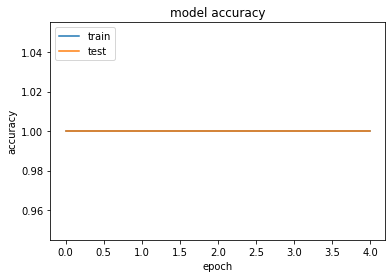

In [46]:
# accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

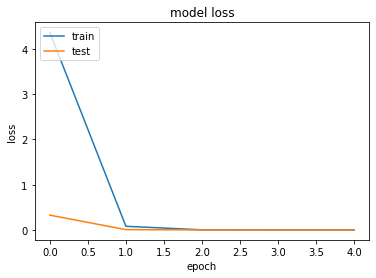

In [47]:
# loss value
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [40]:
result = model.score(X_test, y_test)
result

AttributeError: 'Sequential' object has no attribute 'score'